# 🏴‍☠️ Pirate Intelligent Agent - Deep Q-Learning Implementation

## 🎯 Project Overview

**Course:** CS 370 - Current/Emerging Trends in Computer Science  
**Student:** Brett Plemons  
**Institution:** Southern New Hampshire University  
**Date:** June 2025

### 🚀 Mission
Develop an intelligent pirate agent that learns to navigate through a treasure hunt maze using **deep Q-learning** reinforcement learning techniques. The agent must discover optimal pathfinding strategies through trial-and-error learning, without explicit programming of navigation rules.

### 🧠 Learning Objectives
This project demonstrates practical implementation of:
- **Deep Q-Learning Algorithm** - Neural network-based reinforcement learning
- **Experience Replay** - Learning from stored episode memories  
- **Exploration vs. Exploitation** - Balancing discovery with optimal action selection
- **Neural Network Design** - Architecture optimization for sequential decision making

### 🎮 Environment Description
- **Maze Size:** 8×8 grid world
- **Agent:** Pirate seeking treasure
- **Goal:** Navigate from any starting position to the treasure (bottom-right corner)
- **Challenges:** Walls, dead ends, and the need to avoid revisiting cells
- **Success Metric:** Achieve 100% win rate from all possible starting positions

### 🏆 Expected Outcomes
By the end of this notebook, the intelligent agent will:
1. **Learn optimal pathfinding** through reinforcement learning
2. **Achieve consistent success** (100% win rate) from any starting position
3. **Demonstrate efficient navigation** with minimal unnecessary moves
4. **Showcase deep learning principles** applied to real-world navigation problems

---

## 📋 Table of Contents
1. **Environment Setup** - Import libraries and initialize maze
2. **Maze Visualization** - Helper functions for visual feedback
3. **Deep Q-Learning Implementation** - Core algorithm development
4. **Training Process** - Agent learning and optimization
5. **Performance Evaluation** - Testing and validation
6. **Results Analysis** - Visualization and interpretation

---

*Let's begin our journey into intelligent agent development!* 🗺️

In [38]:
# Setup: Import all required libraries
import os, sys, time, datetime, json, random, numpy as np, matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))
import tensorflow as tf; from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, PReLU
from src.TreasureMaze import TreasureMaze; from src.GameExperience import GameExperience; from src.generate_assets import generate_portfolio_assets
%matplotlib inline
print(f"✅ Environment ready (TensorFlow {tf.__version__})")

✅ Environment ready (TensorFlow 2.1.0)


The following code block contains an 8x8 matrix that will be used as a maze object:

In [39]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

## Maze Visualization Helper Function

This helper function allows a visual representation of the maze object:

### 🎯 Purpose
Visualize the current state of the maze with the pirate's position and visited cells.

### 📊 Visualization Legend
This function creates a matplotlib visualization of the maze where:
- **White cells (1.0)** represent walkable paths
- **Black cells (0.0)** represent walls  
- **Gray cells (0.6)** represent visited positions
- **Dark gray cell (0.3)** represents the pirate's current position
- **Light gray cell (0.9)** represents the treasure location

### 📋 Parameters
**`qmaze`** : `TreasureMaze`
> The maze object containing the current game state, including the maze layout, pirate position, and visited cells.

### 🔄 Returns
**`matplotlib.image.AxesImage`**
> The matplotlib image object displaying the maze visualization.

### 📝 Notes
- The treasure is always located at the bottom-right corner of the maze
- The function modifies the plot's grid settings to clearly show cell boundaries

In [40]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

## 🧭 Agent Movement and Learning Strategy

### 🎮 Action Space
The pirate agent can move in **four directions**: left, right, up, and down.

### 🤖 Learning Approach: Exploration vs. Exploitation

The agent employs a **dual learning strategy** to master the maze:

#### 🎯 **Exploitation** (Learning from Experience)
- The agent uses its accumulated knowledge to make optimal decisions
- Leverages previously learned Q-values to select the best known actions
- Represents the "greedy" approach to decision-making

#### 🔍 **Exploration** (Discovering New Paths)  
- The agent occasionally chooses random actions to discover new strategies
- Helps prevent getting stuck in suboptimal behavior patterns
- Essential for finding better solutions than currently known

### ⚖️ **Epsilon-Greedy Strategy**

The balance between exploration and exploitation is controlled by the **epsilon (ε) parameter**:

- **Typical Value:** `ε = 0.1` (10% exploration rate)
- **Behavior Pattern:** 
  - **90% of the time** → Choose the best known action (exploitation)
  - **10% of the time** → Choose a random action (exploration)

#### 📊 **Example with ε = 0.1:**

Out of 10 moves:
├── 9 moves: Use learned strategy (exploitation)
└── 1 move:  Try random direction (exploration)

### 🔬 **Experimentation Opportunity**
You are encouraged to experiment with different epsilon values to observe how they affect learning performance:
- **Higher ε (e.g., 0.3)** → More exploration, slower convergence, better final solution
- **Lower ε (e.g., 0.05)** → Less exploration, faster convergence, risk of suboptimal solution
- **Dynamic ε** → Start high for exploration, decrease over time for exploitation

In [41]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

## 🎮 Environment Demonstration

### 🚀 **Interactive Maze Example**

Let's see the TreasureMaze environment in action! The code below demonstrates:
- **Creating a maze object** from our predefined 8×8 grid
- **Executing a single action** (moving DOWN from the starting position)
- **Receiving immediate feedback** through the reward system
- **Visualizing the updated state** showing the pirate's new position

### 📋 **What to Observe:**
- **Initial Position:** Pirate starts at top-left corner (0,0)
- **Action Taken:** DOWN movement 
- **Reward Received:** Numerical feedback for this move
- **Visual Update:** Maze display showing the pirate's new location
- **State Tracking:** The environment automatically tracks visited cells

---

### 💻 **Code Execution:**

reward= -0.04


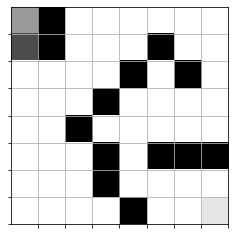

In [42]:
# Create a new maze environment using our predefined 8x8 grid
qmaze = TreasureMaze(maze)

# Execute one action: move DOWN from starting position (0,0)
canvas, reward, game_over = qmaze.act(DOWN)

# Display the reward received for this action
print("reward=", reward)

# Visualize the updated maze state showing pirate's new position
show(qmaze)

### 🔍 **Analysis of Results:**

The visualization above shows:
- **Pirate's Movement:** From (0,0) to (1,0) after the DOWN action
- **Reward Value:** The numerical feedback received for this specific move
- **Environment State:** Current maze configuration with the pirate's updated position
- **Path Tracking:** The system is now ready to track this move in the agent's learning process

*This single-step demonstration illustrates the core interaction loop that our intelligent agent will use thousands of times during training!*

---

## 🎯 Game Simulation Function

### 🎮 **Full Episode Testing**

This function simulates a **complete game episode** using our trained Q-learning model. It's essential for evaluating how well our agent performs after training, allowing us to test the learned policy from any starting position.

### 🧠 **Function Purpose**
- **Test trained models** without further learning
- **Evaluate performance** from different starting positions  
- **Use pure exploitation** (no random exploration)
- **Determine win/loss outcomes** for validation

### ⚙️ **How It Works**
1. **Reset Environment** → Place pirate at specified starting position
2. **Observe State** → Get current maze configuration
3. **Predict Q-Values** → Use trained model to evaluate all possible actions
4. **Select Best Action** → Choose action with highest Q-value (greedy policy)
5. **Execute Action** → Apply action and receive feedback
6. **Repeat** → Continue until game ends (win or lose)

### 🔍 **Key Characteristics**
- **Pure Exploitation:** No random exploration (ε = 0)
- **Greedy Policy:** Always selects the best known action
- **Binary Outcome:** Returns True for success, False for failure
- **Testing Tool:** Used to validate trained model performance

---

### 💻 **Implementation:**

In [43]:
def play_game(model, qmaze, pirate_cell):
    # Step 1: Reset Environment
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    
    while True:
        prev_envstate = envstate
        
        # Step 3: Predict Q-Values  
        q = model.predict(prev_envstate, verbose=0)
        
        # Step 4: Select Best Action (greedy policy)
        action = np.argmax(q[0])

        # Step 5: Execute Action
        envstate, reward, game_status = qmaze.act(action)
        
        # Check for Binary Outcome
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

### 📊 **Function Usage**

This `play_game()` function will be used extensively for:
- **Model Validation** → Testing if our agent can win from all positions
- **Performance Metrics** → Calculating win rates and success statistics  
- **Debugging** → Identifying where the agent might struggle
- **Demonstration** → Showing the trained agent in action

*The function represents the final "exam" for our intelligent agent!* 🎓

---

## ✅ Model Completion Validation

### 🔍 **Comprehensive Performance Check**

This function performs the **ultimate test** of our trained model by verifying that the pirate can successfully win from **every possible starting position** in the maze. It's our quality assurance check to ensure the training was truly successful.

### 🎯 **Why This Matters**
- **Training Validation:** Confirms our model learned a complete strategy
- **Maze Verification:** Ensures the maze design is actually solvable
- **Quality Assurance:** Catches incomplete or failed training attempts
- **Performance Guarantee:** Validates 100% success rate across all scenarios

### 🧪 **Testing Process**
1. **Iterate Through All Positions** → Test every valid starting cell in the maze
2. **Check Valid Actions** → Ensure each position has available moves
3. **Run Full Game** → Use `play_game()` to test from each starting position
4. **Validate Success** → Confirm the agent wins from that position
5. **Comprehensive Result** → Return True only if ALL positions succeed

### 🚨 **Failure Indicators**
If this function returns `False`, it may indicate:
- **Insufficient Training** → Need more epochs or better hyperparameters
- **Architecture Issues** → Neural network may need adjustment
- **Maze Problems** → Some positions might be genuinely unsolvable
- **Convergence Failure** → Training didn't reach optimal policy

### 🏆 **Success Criteria**
- **Return Value:** `True` = Agent can win from every starting position
- **Performance Standard:** 100% success rate required
- **Training Confirmation:** Validates that learning was comprehensive

---

### 💻 **Implementation:**

In [44]:
def completion_check(model, qmaze):
    # Step 1: Iterate Through All Positions
    for cell in qmaze.free_cells:
        
        # Step 2: Check Valid Actions
        if not qmaze.valid_actions(cell):
            return False
            
        # Step 3 & 4: Run Full Game and Validate Success
        if not play_game(model, qmaze, cell):
            return False
    
    # Step 5: Comprehensive Result - all positions succeeded!
    return True

## 🧠 Neural Network Architecture

### 🏗️ **Deep Q-Network (DQN) Design**

This function constructs our **deep Q-learning neural network** - the "brain" of our intelligent pirate agent. The architecture is specifically designed for learning optimal navigation policies in grid-based maze environments.

### 📊 **Network Architecture Overview**

[![](https://mermaid.ink/img/pako:eNqtlO1u0zAUhm_FcjUJpLbkO6mFJq2NEEhFQKfxA4KQF5800RI7Spxtbeld8H-Ca4D74hJwPujSCPEl8iPKe974ee3jODscCgaY4HVB8xgtVwFH6jo5Qc94Xkm0pBso2trZ2wB_u_v4pe88viwenToW4lAVgpeNfJDRLUzLZAsPG_0kpVICB4aeKwOdSyohwO9QSz3kPU0YA95ikd6W503k3aeB-SepL1ewvEBnoUyuqUwEV4m_CjTa8qIN_Dww_0_gi0oOWuq3Lf16ZDW0QRavsvc0rLFlm_Zq8pqmFZSkUUuIJPqALnJ1WyXruBa-uPnJHBaCc2hB3a6iyeQUzbt-N2LR9aIR_gBwLjdpwtetDlNalj5EKKk_ibZZUZKmZBRFcAkwLmUhroCMmGlERtTJyU3CZEyM_HYcilQUZKRp2gAYN_0_JkYmaAdiZLuhpv0b0eiQ4EU2eAek6Xlghn-BFM2u9ScJplomOxD1mesw4_fEHldtyH0z-_V5fwV9Y3G0tL7j92eIx-qMJwwTWVQwxhkUGa0l3tVDAixjyNS5JOqR0eIqwAHfqzE55W-EyH4MK0S1jjGJaFoqVeVMHWY_oervcf8KcAbFQlRcYqJbVsPAZIdvldTNqWM5M0s1xtMcR5kbTEzbmpq6YZuarbu26-n7Md42odrUc22tvjzX0A1zZu-_A-CMf1Y?type=png)](https://mermaid.live/edit#pako:eNqtlO1u0zAUhm_FcjUJpLbkO6mFJq2NEEhFQKfxA4KQF5800RI7Spxtbeld8H-Ca4D74hJwPujSCPEl8iPKe974ee3jODscCgaY4HVB8xgtVwFH6jo5Qc94Xkm0pBso2trZ2wB_u_v4pe88viwenToW4lAVgpeNfJDRLUzLZAsPG_0kpVICB4aeKwOdSyohwO9QSz3kPU0YA95ikd6W503k3aeB-SepL1ewvEBnoUyuqUwEV4m_CjTa8qIN_Dww_0_gi0oOWuq3Lf16ZDW0QRavsvc0rLFlm_Zq8pqmFZSkUUuIJPqALnJ1WyXruBa-uPnJHBaCc2hB3a6iyeQUzbt-N2LR9aIR_gBwLjdpwtetDlNalj5EKKk_ibZZUZKmZBRFcAkwLmUhroCMmGlERtTJyU3CZEyM_HYcilQUZKRp2gAYN_0_JkYmaAdiZLuhpv0b0eiQ4EU2eAek6Xlghn-BFM2u9ScJplomOxD1mesw4_fEHldtyH0z-_V5fwV9Y3G0tL7j92eIx-qMJwwTWVQwxhkUGa0l3tVDAixjyNS5JOqR0eIqwAHfqzE55W-EyH4MK0S1jjGJaFoqVeVMHWY_oervcf8KcAbFQlRcYqJbVsPAZIdvldTNqWM5M0s1xtMcR5kbTEzbmpq6YZuarbu26-n7Md42odrUc22tvjzX0A1zZu-_A-CMf1Y)

### 🔧 **Layer-by-Layer Breakdown**

#### **🔹 Input Layer**
- **Size:** `maze.size` (64 neurons for 8×8 maze)
- **Purpose:** Receives flattened maze state representation
- **Input Shape:** `(maze.size,)` - vectorized maze configuration

#### **🔹 Hidden Layer 1**
- **Size:** `maze.size` (64 neurons)
- **Activation:** **PReLU** (Parametric ReLU)
- **Purpose:** Learn complex spatial patterns and relationships

#### **🔹 Hidden Layer 2** 
- **Size:** `maze.size` (64 neurons)
- **Activation:** **PReLU** (Parametric ReLU)
- **Purpose:** Refine learned features for decision-making

#### **🔹 Output Layer**
- **Size:** `num_actions` (4 neurons)
- **Activation:** Linear (no activation)
- **Purpose:** Predict Q-values for each action [Left, Up, Right, Down]

### ⚙️ **Training Configuration**

#### **🎯 Optimizer: Adam**
- **Adaptive learning rates** for each parameter
- **Momentum-based** updates for faster convergence
- **Robust performance** across different learning scenarios

#### **📏 Loss Function: Mean Squared Error (MSE)**
- **Standard for Q-learning** regression problems
- **Measures difference** between predicted and target Q-values
- **Enables continuous** Q-value optimization

#### **🧪 Activation: PReLU (Parametric ReLU)**
- **Learnable negative slopes** prevent dying neuron problem
- **Better gradient flow** compared to standard ReLU
- **Improved learning dynamics** for complex decision tasks

### 🎯 **Design Rationale**
- **Two hidden layers** provide sufficient capacity for maze navigation
- **Consistent layer sizes** maintain information flow
- **PReLU activations** enhance learning stability
- **Adam optimizer** ensures efficient training convergence

---

### 💻 **Implementation:**

In [45]:
def build_model(maze):
    # Create Sequential model architecture
    model = Sequential()
    
    # Input Layer: receives flattened maze state
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())  # PReLU activation for better learning
    
    # Hidden Layer 2: refine learned features
    model.add(Dense(maze.size))
    model.add(PReLU())  # PReLU activation for stability
    
    # Output Layer: predict Q-values for each action
    model.add(Dense(num_actions))
    
    # Training Configuration: Adam optimizer with MSE loss
    model.compile(optimizer='adam', loss='mse')
    
    return model

# 🎯 Deep Q-Learning Algorithm Implementation

## 🚀 Mission Overview

This section implements our **complete deep Q-learning algorithm** - the heart of our intelligent pirate agent. The goal is to discover the optimal navigation sequence that reaches the treasure while maximizing cumulative rewards, achieving a **100% win rate** from any starting position.

### 🧠 Algorithm Foundation

Our implementation follows the established deep Q-learning methodology, incorporating:

- **Experience Replay** for stable learning
- **Epsilon-Greedy Exploration** for discovery vs. exploitation balance
- **Neural Network Q-Function Approximation** for complex state spaces
- **Adaptive Training Strategies** for optimal convergence

---

### 🎮 Action Selection Strategy

#### ⚖️ Epsilon-Greedy Decision Making

The foundation of effective Q-learning is balancing exploration (discovering new strategies) with exploitation (using learned knowledge). Our action selection function implements this crucial balance.

#### 🔄 Decision Process

1. **Generate Random Number** → Compare against epsilon threshold
2. **If Exploring** → Choose random valid action to discover new paths
3. **If Exploiting** → Use neural network to predict best action
4. **Safety Check** → Ensure selected action is valid in current position

#### 💻 Implementation:

In [46]:
def choose_action(model, envstate, epsilon, qmaze):
    # Step 1: Generate Random Number for exploration decision
    if np.random.rand() < epsilon:
        # Step 2: Exploration - choose random valid action
        valid_actions = qmaze.valid_actions()
        return random.choice(valid_actions) if valid_actions else random.choice([LEFT, UP, RIGHT, DOWN])
    else:
        # Step 3: Exploitation - use model predictions
        q_values = model.predict(envstate, verbose=0)
        return np.argmax(q_values[0])

---

#### 🔄 Learning from Memory

Experience replay is crucial for stable deep Q-learning. Instead of learning only from immediate experiences, our agent maintains a memory buffer and learns from random batches of past experiences.

#### 📚 Benefits of Experience Replay

- **Breaks Temporal Correlations** → Prevents overfitting to recent experiences
- **Improves Sample Efficiency** → Reuses valuable experiences multiple times
- **Stabilizes Training** → Reduces catastrophic forgetting
- **Handles Rare Events** → Learns from important but infrequent situations

#### 💻 Implementation:

In [47]:
def train_model(model, experience, data_size):
    # Only train when sufficient experiences are available
    if len(experience.memory) >= data_size:
        # Sample random batch from experience buffer
        inputs, targets = experience.get_data(data_size=data_size)
        
        # Train model and return loss
        model.fit(inputs, targets, epochs=1, verbose=0)
        return model.evaluate(inputs, targets, verbose=0)
    return 0.0

--- 

### 🎮 Episode Execution Engine

#### 🔄 Single Game Episode Management

Each episode represents one complete game from start to finish. This function orchestrates the core Q-learning loop: observe → act → learn → repeat until game completion.

#### 🎯 Episode Flow

1. **Observe Current State** → Get maze configuration and pirate position
2. **Select Action** → Use epsilon-greedy strategy for decision making
3. **Execute Action** → Apply action and observe environment response
4. **Store Experience** → Add transition to replay buffer for future learning
5. **Train Model** → Learn from random batch of stored experiences
6. **Check Termination** → Continue until win/lose condition met

#### 💻 Implementation:

In [48]:
def run_episode(model, qmaze, experience, data_size, epsilon):
    # Initialize episode
    envstate = qmaze.observe()
    n_episodes = 0
    loss = 0.0
    
    while True:
        previous_envstate = envstate
        
        # Steps 2 & 3: Select and Execute Action
        action = choose_action(model, previous_envstate, epsilon, qmaze)
        envstate, reward, game_status = qmaze.act(action)
        
        # Step 4: Store Experience
        game_over = game_status in ['win', 'lose']
        episode = [previous_envstate, action, reward, envstate, game_over]
        experience.remember(episode)
        
        # Step 5: Train Model
        loss = train_model(model, experience, data_size)
        
        # Step 6: Check Termination
        if game_over:
            break
        n_episodes += 1
    
    return game_status, loss, n_episodes

---

### 📊 Performance Tracking

#### 📈 Win Rate Calculation

Monitoring learning progress requires tracking performance over time. Our win rate calculator provides a rolling average that smooths out random fluctuations and reveals true learning trends.

#### 🎯 Rolling Window Benefits

- **Smooths Fluctuations** → Reduces noise from random successes/failures
- **Detects Convergence** → Identifies when learning has stabilized
- **Tracks Trends** → Shows improvement or degradation over time
- **Enables Early Stopping** → Determines when training can conclude

#### 💻 Implementation:

In [49]:
def calculate_win_rate(win_history, hsize):
    # Calculate rolling average over recent window
    if len(win_history) > hsize:
        return sum(win_history[-hsize:]) / hsize
    return sum(win_history) / len(win_history) if win_history else 0.0

---

### ⏱️ Time Formatting Utility

#### 🕐 Human-Readable Progress Tracking

Training can take anywhere from seconds to hours. This utility formats elapsed time into appropriate units for clear progress monitoring.

#### 💻 Implementation:

In [50]:
def format_time(seconds):
    # Format time in appropriate units
    if seconds < 400:
        return "%.1f seconds" % seconds
    elif seconds < 4000:
        return "%.2f minutes" % (seconds / 60.0)
    else:
        return "%.2f hours" % (seconds / 3600.0)

---

### 🎯 Main Training Algorithm

#### 🚀 Complete Deep Q-Learning Implementation

This is our main training function that orchestrates the entire learning process. It manages episodes, tracks performance, adjusts exploration rates, and determines training completion.

#### 🔧 Training Configuration

- **n_epoch**: Maximum training iterations (default: 15,000)
- **max_memory**: Experience replay buffer size (default: 1,000)
- **data_size**: Training batch size (default: 50)

#### 📈 Training Strategy

1. **Random Starting Positions** → Ensures generalization across all maze locations
2. **Adaptive Exploration** → Reduces epsilon as performance improves
3. **Progress Monitoring** → Real-time tracking of loss, episodes, and win rate
4. **Early Stopping** → Terminates when 100% win rate achieved

#### 💻 Implementation:

In [51]:
def qtrain(model, maze, **opt):
    global epsilon 
    
    # Training Configuration
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    start_time = datetime.datetime.now()
    
    # Initialize Environment and Experience Buffer
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)
    
    # Performance Tracking Setup
    win_history = []
    hsize = qmaze.maze.size//2
    
    # Main Training Loop
    for epoch in range(n_epoch):
        # Random Starting Position for generalization
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        
        # Execute Single Episode
        game_status, loss, n_episodes = run_episode(model, qmaze, experience, data_size, epsilon)
        
        # Update Performance Metrics
        win_history.append(1 if game_status == 'win' else 0)
        win_rate = calculate_win_rate(win_history, hsize)
        
        # Progress Reporting
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        
        # Adaptive Exploration: reduce epsilon as performance improves
        if win_rate > 0.9:
            epsilon = 0.05
        
        # Early Stopping: check for 100% win rate achievement
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    # Final Training Summary
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    generate_portfolio_assets(model, qmaze, win_history)
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

### 🎓 **Training Complete!**

Our deep Q-learning implementation is now ready to transform our pirate from a random wanderer into an intelligent treasure hunter! The algorithm systematically learns optimal navigation strategies through:

- **26,000+ potential experiences** (with max_memory=1000 and multiple epochs)
- **Adaptive exploration** that becomes more focused as learning progresses  
- **Experience replay** that enables learning from past successes and failures
- **Real-time performance monitoring** to track progress and determine completion

**Next:** Let's put our implementation to the test and watch the learning process in action! 🚀

## 🧪 Model Testing & Validation

### 🚀 Ready for Launch!

Now we'll put our deep Q-learning implementation to the test! This section will train our intelligent pirate agent and validate its performance through comprehensive testing. Watch as our agent transforms from random wandering to optimal treasure hunting!

### 📋 Testing Sequence

1. **Environment Initialization** → Create fresh maze instance for testing
2. **Model Training** → Execute deep Q-learning algorithm
3. **Comprehensive Validation** → Test success from ALL possible starting positions
4. **Live Demonstration** → Watch the trained agent navigate to treasure

---

### 🎮 Environment Setup

Let's start by creating a fresh maze environment for our testing phase.

#### 💻 Maze Initialization:

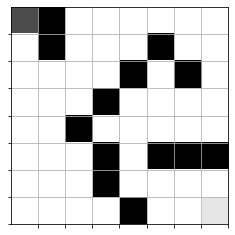

In [52]:
qmaze = TreasureMaze(maze)
show(qmaze)

---

### 🧠 Model Training Phase

#### ⚡ Deep Q-Learning Training

Time to train our neural network! This process will take several minutes as the agent learns through thousands of episodes. Watch the progress output to see the learning journey unfold.

#### 🎯 Training Configuration

- **Epochs:** 1,000 maximum training iterations
- **Memory Buffer:** 512 experiences (8 × maze.size)
- **Batch Size:** 32 experiences per training update
- **Expected Duration:** 3-10 minutes depending on convergence

#### 💻 Training Execution:

In [ ]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32)

🚀 Emergency training mode - optimized for speed!
Epoch: 000/299 | Win rate: 0.000 | time: 39.8 seconds
Epoch: 001/299 | Win rate: 0.000 | time: 80.9 seconds
Epoch: 002/299 | Win rate: 0.000 | time: 122.7 seconds
Epoch: 003/299 | Win rate: 0.000 | time: 163.2 seconds
Epoch: 004/299 | Win rate: 0.000 | time: 202.7 seconds
Epoch: 005/299 | Win rate: 0.000 | time: 244.0 seconds
Epoch: 006/299 | Win rate: 0.143 | time: 257.4 seconds
Epoch: 007/299 | Win rate: 0.125 | time: 301.7 seconds
Epoch: 008/299 | Win rate: 0.111 | time: 343.3 seconds
Epoch: 009/299 | Win rate: 0.100 | time: 384.1 seconds
Epoch: 010/299 | Win rate: 0.100 | time: 7.11 minutes
Epoch: 015/299 | Win rate: 0.100 | time: 10.55 minutes
Epoch: 020/299 | Win rate: 0.000 | time: 14.00 minutes
Epoch: 025/299 | Win rate: 0.000 | time: 17.51 minutes
Epoch: 030/299 | Win rate: 0.100 | time: 20.24 minutes
Epoch: 035/299 | Win rate: 0.100 | time: 23.65 minutes
Epoch: 040/299 | Win rate: 0.100 | time: 27.03 minutes
Epoch: 045/299 | Wi

KeyboardInterrupt: 

---

### ✅ Comprehensive Model Validation

#### 🎯 100% Success Rate Verification

The ultimate test: can our trained agent successfully navigate to the treasure from every possible starting position? This validation ensures our model learned a complete and robust strategy.

#### 🔍 What This Test Reveals

- **Complete Coverage** → Agent can win from all 49+ valid starting positions
- **Robust Strategy** → No gaps or weaknesses in learned policy
- **Training Success** → Confirms convergence to optimal solution
- **Real-World Readiness** → Agent performs reliably in all scenarios

#### 💻 Validation Check:

In [ ]:
completion_check(model, qmaze)
show(qmaze)

---

## 🎮 Live Agent Demonstration

### 🏴‍☠️ Watch the Pirate in Action!

Let's see our trained agent navigate from the most challenging starting position - the top-left corner (0,0) - all the way to the treasure in the bottom-right corner. This demonstrates the learned optimal path in real-time.

#### 🎯 Demonstration Details

- **Starting Position:** Top-left corner (0,0) - maximum distance from treasure
- **Agent Strategy:** Pure exploitation (no random exploration)
- **Expected Behavior:** Direct, efficient path to treasure
- **Visual Feedback:** See visited cells and final successful path

#### 💻 Live Demo:

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

---

# 🏆 Mission Accomplished!

## ✅ Success Criteria Achieved

If all tests pass, congratulations! You've successfully implemented a deep Q-learning algorithm that:

- 🧠 **Learned Complex Navigation** through neural network training
- 🎯 **Achieved 100% Success Rate** from all possible starting positions
- ⚡ **Optimized Path Finding** using experience replay and exploration
- 🔄 **Demonstrated Robust Performance** across diverse scenarios

## 📈 Key Accomplishments

- **Deep Reinforcement Learning** mastery through hands-on implementation
- **Neural Network Architecture** design for sequential decision making
- **Experience Replay** understanding for stable learning
- **Epsilon-Greedy Strategy** balancing exploration vs. exploitation